In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report,auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import plotly.express as px
import shap
shap.initjs()



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# HEART DATA

## Attribute description


Age: age of the patient

Sex: sex of the patient (M,F)

ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain
                ASY: Asymptomatic
                
RestingBP: resting blood pressure mmHg

Cholesterol: serum cholesterol mm/dl

FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)

RestingECG: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality    LVH: showing probable or definite left ventricular hypertrophy 

MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)

ExerciseAngina: exercise-induced angina (Y: Yes, N: No)

Oldpeak: oldpeak = ST (Numeric value measured in depression)

ST_Slope: the slope of the peak exercise ST segment (Up, Flat, Down)

HeartDisease: output class (1: heart disease, 0: Normal)

REFERENCE: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data


### Read the data and display basic data information and check whether the target is balanced

In [3]:
heart = pd.read_csv('data/bigheart.csv')

print(heart.shape)
print(heart.head())

from collections import Counter
print(Counter(heart['HeartDisease']))  

heart.describe()

                               

(918, 12)
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
Counter({1: 508, 0: 410})


Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000

##  Missing values investigation

In [4]:
heart.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Great. No missing values

##  Separate numerical from categorical features

In [5]:

heart2 = heart.copy(deep = True)
numeric_data = heart2.select_dtypes(include=[np.number])
numeric_data.drop(["FastingBS","HeartDisease"],axis=1,inplace=True)
print(numeric_data.columns)
categorical_data = heart2.select_dtypes(exclude=[np.number])
categorical_data["FastingBS"]=heart2["FastingBS"]
print(categorical_data.columns)
for col in categorical_data:
    print(Counter(heart2[col]))  

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], dtype='object')
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',
       'FastingBS'],
      dtype='object')
Counter({'M': 725, 'F': 193})
Counter({'ASY': 496, 'NAP': 203, 'ATA': 173, 'TA': 46})
Counter({'Normal': 552, 'LVH': 188, 'ST': 178})
Counter({'N': 547, 'Y': 371})
Counter({'Flat': 460, 'Up': 395, 'Down': 63})
Counter({0: 704, 1: 214})


## One hot encoding

In [6]:
heart2 = pd.get_dummies(heart, columns=['Sex', 'ChestPainType', 'RestingECG','ExerciseAngina',\
                                        'ST_Slope'])

## Correlation Heat Map

<AxesSubplot: >

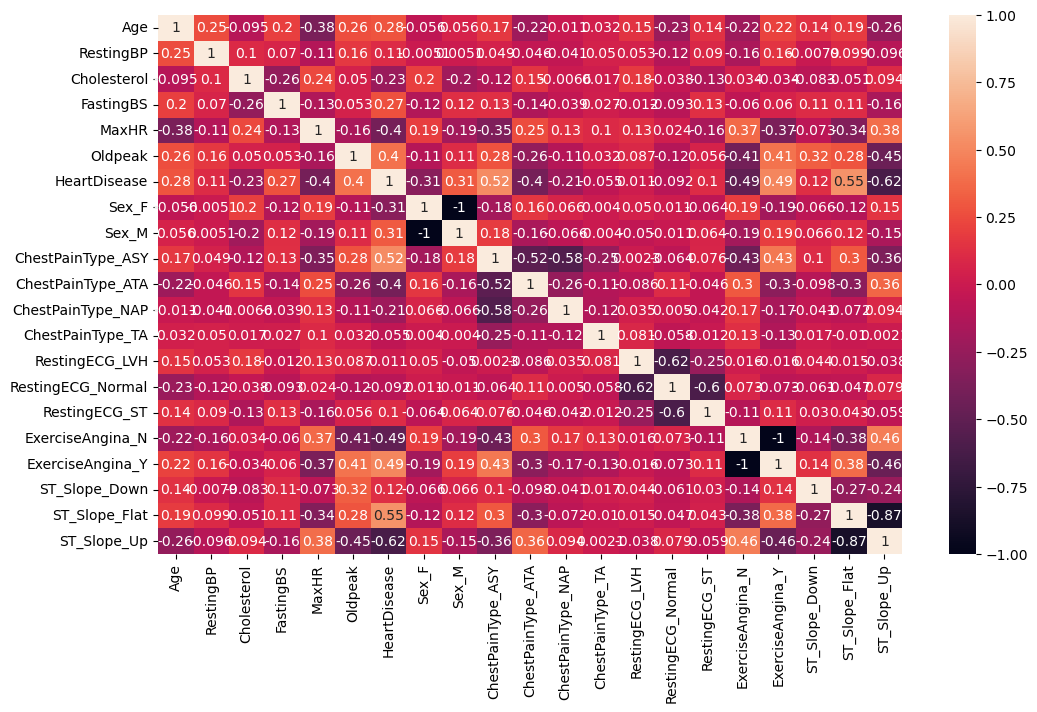

In [7]:
corr = heart2.corr()
plt.figure(figsize = (12,7))
sns.heatmap(corr,annot=True, )

# -----------------------------------------------------

# Creation of Training and Testing Datasets

### Create X and y

In [7]:
X = heart2.drop('HeartDisease',axis=1)
y = heart2['HeartDisease']
# GET THE NAMES OF FEATURES FOR LATER USE
column_headers = list(X.columns.values)
print("The Column Header :", column_headers)


The Column Header : ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


### Mutual info for features

[0.04877843 0.01015123 0.06536283 0.05891859 0.09688588 0.11425689
 0.01674177 0.05719141 0.16434267 0.07871048 0.03089366 0.00492383
 0.01595712 0.         0.         0.14308996 0.14828166 0.00599247
 0.15565419 0.20807321]


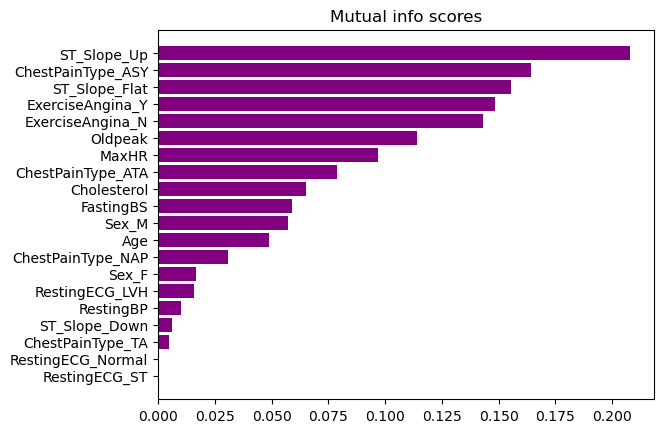

In [8]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_scores = MIC(X,y)
print(mi_scores)
mut_scores = pd.Series(mi_scores, index=column_headers)
sort_indices = np.argsort(mut_scores)
plt.title('Mutual info scores')
plt.barh(range(len(sort_indices)), mut_scores[sort_indices], color='purple', align='center')
plt.yticks(range(len(sort_indices)), [column_headers[i] for i in sort_indices])
plt.show()

### Split Into Training and Testing Set Using Stratify

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42, stratify=y)



# This is needed for package that needs a Series as input.
y_trainorig=y_train
# THIS IS NEEDED FOR THE FIT FUNCTION OF THE ESTIMATORS. THE SERIES NEEDS TO BE CONVERTED TO 
#A 1-D ARRAY.

y_train= y_train.to_numpy()
y_test= y_test.to_numpy()


## SCALING

In [10]:

from sklearn.preprocessing import StandardScaler

ss = StandardScaler() # Standardization

X_train['Oldpeak'] = ss.fit_transform(X_train[['Oldpeak']])
X_train['Age'] = ss.fit_transform(X_train[['Age']])
X_train['RestingBP'] = ss.fit_transform(X_train[['RestingBP']])
X_train['Cholesterol'] = ss.fit_transform(X_train[['Cholesterol']])
X_train['MaxHR'] = ss.fit_transform(X_train[['MaxHR']])
X_trainD=pd.DataFrame(X_train)
print(X_trainD.head())



X_test['Oldpeak'] = ss.fit_transform(X_test[['Oldpeak']])
X_test['Age'] = ss.fit_transform(X_test[['Age']])
X_test['RestingBP'] = ss.fit_transform(X_test[['RestingBP']])
X_test['Cholesterol'] = ss.fit_transform(X_test[['Cholesterol']])
X_test['MaxHR'] = ss.fit_transform(X_test[['MaxHR']])
X_testD=pd.DataFrame(X_test)
print(X_testD.head())

          Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Sex_F  \
53  -1.355475  -0.124065     0.409114          0  0.547019 -0.813147      1   
336  1.921073   1.525069    -1.872279          0 -0.854717  0.673819      0   
135 -0.509914  -0.948632     0.595350          0  1.520447 -0.813147      0   
628  0.758427   0.095820     0.306684          0  0.352333  1.603173      0   
864  0.652732   0.700502     0.753651          0  0.235522  1.789043      0   

     Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
53       0                  0                  1                  0   
336      1                  0                  0                  1   
135      1                  0                  0                  1   
628      1                  0                  0                  0   
864      1                  1                  0                  0   

     ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
53                  0  

# -------------------------------------------------------------

# MODELING AND FEATURE IMPORTANCE CALC BEGINS HERE¶

# Feature Importance Using Interpretation Techniques

## OMNIXAI Package

In [12]:
from omnixai.data.tabular import Tabular
from omnixai.preprocessing.tabular import TabularTransform
from omnixai.explainers.tabular import TabularExplainer
from omnixai.visualization.dashboard import Dashboard
cc=(categorical_data.columns.values).tolist()
Xomni=heart.drop("HeartDisease",axis=1)
column_headers_orig = list(Xomni.columns.values)

tabular_data = Tabular(
    data=heart,
    categorical_columns=cc,
    target_column='HeartDisease'
)

np.random.seed(1)
transformer = TabularTransform().fit(tabular_data)
class_names = transformer.class_names
x = transformer.transform(tabular_data)
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(x[:, :-1], x[:, -1], train_size=0.80)
print('Training data shape: {}'.format(train.shape))
print('Test data shape:     {}'.format(test.shape))


Training data shape: (734, 21)
Test data shape:     (184, 21)


### OMNIXAI Explainers

In [13]:


import xgboost as xgb
from xgboost import XGBClassifier
gbtree = xgb.XGBClassifier(n_estimators=300, max_depth=5)
gbtree.fit(train, train_labels)

# Convert the transformed data back to Tabular instances
train_data = transformer.invert(train)
test_data = transformer.invert(test)
print(train_data)

preprocess = lambda z: transformer.transform(z)

explainers = TabularExplainer(
    #explainers=["lime", "shap", "pdp", "ale"],
    explainers=["lime", "shap"],
    mode="classification",
    data=train_data,
    model=gbtree,
    preprocess=preprocess,
    params={
        "lime": {"kernel_width": 3},
        "shap": {"nsamples": 100},
        }
)

test_instances = test_data[130:135]
local_explanations = explainers.explain(X=test_instances)
#global_explanations=explainers.explain_global(
#    params={"pdp": {"features": column_headers_orig}}
#)
index=1
print("LIME results:")
local_explanations["lime"].ipython_plot(index, class_names=class_names)
print("SHAP results:")
local_explanations["shap"].ipython_plot(index, class_names=class_names)
#print("PDP results:")
#global_explanations["pdp"].ipython_plot(class_names=class_names)
#print("ALE results:")
#global_explanations["ale"].ipython_plot(class_names=class_names)

      Age Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0    43.0   M           ASY      120.0        177.0         0        LVH   
1    52.0   F           NAP      125.0        272.0         0     Normal   
2    65.0   F           ASY      150.0        225.0         0        LVH   
3    41.0   M           ASY      120.0        237.0         1     Normal   
4    50.0   M           ASY      140.0        129.0         0     Normal   
..    ...  ..           ...        ...          ...       ...        ...   
729  54.0   F           NAP      108.0        267.0         0        LVH   
730  52.0   M           ASY      120.0        182.0         0     Normal   
731  63.0   M           ASY      140.0        187.0         0        LVH   
732  39.0   M           ATA      120.0        200.0         0     Normal   
733  41.0   F           ATA      110.0        250.0         0         ST   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  
0    120.0              Y      2.5     Fl

  0%|          | 0/5 [00:00<?, ?it/s]

LIME results:


SHAP results:


## ELI5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

perm = PermutationImportance(SVC(), cv=5)
perm.fit(X_train, y_train)
importances=perm.feature_importances_
eli5_importances = pd.Series(importances, index=column_headers)
sort_indices = np.argsort(eli5_importances)
plt.title('ELI5 Feature Importances')
plt.barh(range(len(sort_indices)), eli5_importances[sort_indices], color='orange', align='center')
plt.yticks(range(len(sort_indices)), [column_headers[i] for i in sort_indices])
plt.show()

## INTERPRET Package

In [15]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

ebm_local = ebm.explain_local(X_test[:43], y_test[:43], name='EBM')
show(ebm_local)


<!-- http://127.0.0.1:7001/1644546269136/ -->

<!-- http://127.0.0.1:7001/1644546330128/ -->

# The DALEX package

In [16]:
import dalex as dx
model_dx = LogisticRegression(C=0.25,max_iter=50)
heart_exp = dx.Explainer(model_dx, X_train, y_train, 
                  label = "Heart Logistic Pipeline")
s=model_dx.fit(X_train, y_train)

mp_rf = heart_exp.model_parts()
mp_rf.result
mp_rf.plot()

pd_rf = heart_exp.model_profile(variables = ['FastingBS', 'Cholesterol'])
pd_rf.plot()

Preparation of a new explainer is initiated

  -> data              : 615 rows 20 cols
  -> target variable   : 615 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Heart Logistic Pipeline
  -> predict function  : <function yhat_proba_default at 0x0000017EE6E27CE0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         :  'residual_function' returns an Error when executed:
This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
  -> model_info        : package sklearn

A new explainer has been created!


C:\Users\theom\anaconda3\envs\myregr\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' returns an Error when executed: 
This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

C:\Users\theom\anaconda3\envs\myregr\Lib\site-packages\dalex\_explainer\object.py:138: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



Calculating ceteris paribus: 100%|███████████████████████████████████████████████████████| 2/2 [00:00<00:00, 60.81it/s]


# FEATURE IMPORTANCE USING FEATURE SELECTION TECHNIQUES

## Feature selection using the Relief Algorithm

In [17]:
from kydavra import ReliefFSelector

selector = ReliefFSelector(10,5)
selected_cols = selector.select(heart2, 'HeartDisease')
print(selected_cols)



['ChestPainType_NAP', 'ExerciseAngina_Y', 'ChestPainType_ASY', 'ST_Slope_Flat', 'Sex_F']


## Feature Selection Using the MRMR algorithm

In [18]:
import mrmr
from mrmr import mrmr_classif
selected_features = mrmr_classif(X, y, K=5)
print(selected_features)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.36it/s]

['ST_Slope_Up', 'ChestPainType_TA', 'Sex_M', 'ChestPainType_ASY', 'ST_Slope_Flat']


## Feature Selection Using the Selective Package

In [11]:
from feature.selector import SelectionMethod, Selective
# Various feature selectors offered
#selector = Selective(SelectionMethod.Variance(threshold=0.0))
#selector = Selective(SelectionMethod.Correlation(threshold=0.5, method="pearson"))
#selector = Selective(SelectionMethod.Statistical(num_features=3, method="anova"))
#selector = Selective(SelectionMethod.Linear(num_features=3, regularization="none"))
selector = Selective(SelectionMethod.TreeBased(num_features=5))

# Feature selection
subset = selector.fit_transform(X_train, y_trainorig)
print("Selected Features:", list(subset.columns))


Selected Features: ['Cholesterol', 'MaxHR', 'Oldpeak', 'ChestPainType_ASY', 'ST_Slope_Up']


## Feature Selection Using SelectFromModel

In [17]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

model_etc = ExtraTreesClassifier(n_estimators=50)
model_etc.fit(X_train, y_train)
selecti = SelectFromModel(model_etc, prefit=True)
new_F = pd.DataFrame(columns = ['Feature', 'Selection'])
new_F['Feature'] = X_train.columns
new_F['Selection'] = selecti.get_support().tolist()
new_FF = new_F[new_F['Selection']==True]
selected_features= new_FF['Feature'].tolist()
print(selected_features)




['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Flat', 'ST_Slope_Up']


## Feature Selection Using the PYIMPETUS Package

Progress bar: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


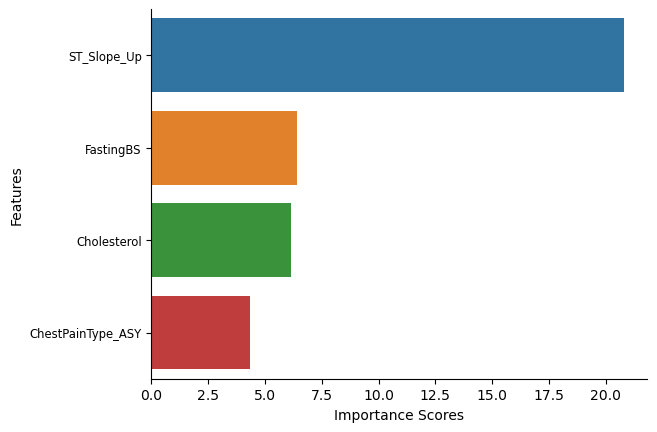

In [37]:
# Import the algorithm. PPIMBC is for classification
from PyImpetus import PPIMBC

from sklearn.svm import SVC

# Initialize the PyImpetus object
model = PPIMBC(model=SVC(random_state=27, class_weight="balanced"), p_val_thresh=0.05, num_simul=30, simul_size=0.2, simul_type=0, sig_test_type="non-parametric", cv=5, random_state=27, n_jobs=-1, verbose=2)
# The fit_transform function is a wrapper for the fit and transform functions, individually.
# The fit function finds the MB for given data while transform function provides the pruned form of the dataset
df_train = model.fit_transform(X_train, y_train)

# Get a plot of the feature importance scores
model.feature_importance()

## Feature Selection Using SelectKBest


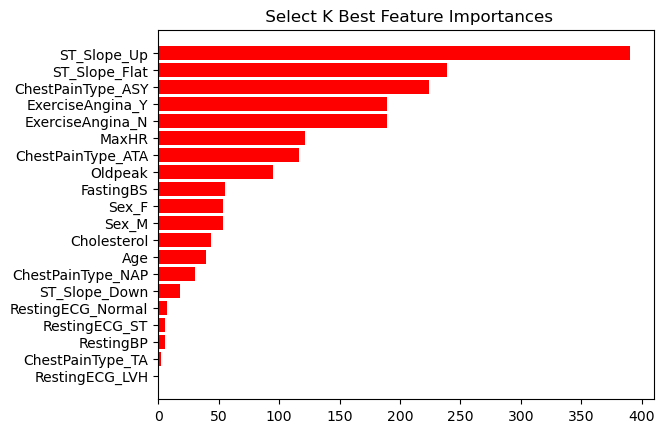

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# feature selection
f_selector = SelectKBest(score_func=f_classif, k=5)
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
#X_train_fs = f_selector.transform(X_train)

#newd=pd.DataFrame(X_train_fs)
#print(newd.head())
# Plot the scores for the features

ssf_importances = pd.Series(f_selector.scores_, index=column_headers)
sortindices = np.argsort(ssf_importances)
plt.title(' Select K Best Feature Importances')
plt.barh(range(len(sortindices)), ssf_importances[sortindices], color='red', align='center')
plt.yticks(range(len(sortindices)), [column_headers[i] for i in sortindices])
plt.show()



## EMBEDDED FILTER SELECTION TECHNIQUES

## Feature Selection Using Logistic Regression 

### Find the best hyperparameters for logistic regression

In [8]:


lr=LogisticRegression()
LR_grid = {'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

CV_lr = GridSearchCV(estimator=lr, param_grid=LR_grid, cv= 5)
CV_lr.fit(X_train, y_train)
CV_lr.best_params_

{'C': 0.25, 'max_iter': 50}

### Logistic Regression Implementation, Metrics Computation and Feature Importance

In [9]:
model1 = LogisticRegression(C=0.25,max_iter=50)
s=model1.fit(X_train, y_train)
model1_predict = model1.predict(X_test)
model1_conf_matrix = confusion_matrix(y_test, model1_predict)
model1_acc_score = accuracy_score(y_test, model1_predict)
print("confusion matrix")
print(model1_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",model1_acc_score*100,'\n')
print(classification_report(y_test,model1_predict))
#log_odds = model1.coef_[0]
#odds = np.exp(model1.coef_[0])
ll = model1.coef_[0]
pd.DataFrame(ll, X.columns, columns=['coef']).sort_values(by='coef', ascending=False)








confusion matrix
[[114  21]
 [ 14 154]]


Accuracy of Logistic Regression: 88.44884488448845 

              precision    recall  f1-score   support

           0       0.89      0.84      0.87       135
           1       0.88      0.92      0.90       168

    accuracy                           0.88       303
   macro avg       0.89      0.88      0.88       303
weighted avg       0.88      0.88      0.88       303



coef
ChestPainType_ASY  1.091887
FastingBS          0.863633
ST_Slope_Flat      0.829780
Sex_M              0.463849
ExerciseAngina_Y   0.382341
Oldpeak            0.294517
ST_Slope_Down      0.277960
RestingECG_LVH     0.207710
Age                0.027053
RestingBP          0.000638
RestingECG_ST     -0.097332
RestingECG_Normal -0.110399
ChestPainType_TA  -0.193232
MaxHR             -0.298876
ExerciseAngina_N  -0.382362
ChestPainType_ATA -0.388795
Sex_F             -0.463869
Cholesterol       -0.475150
ChestPainType_NAP -0.509880
ST_Slope_Up       -1.107760

## Random Forest Classification


### Hyperparameter estimation

In [65]:

from sklearn.model_selection import GridSearchCV

ran_for_cl=RandomForestClassifier(random_state=30)
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10,20,30],
    'criterion' :['gini', 'entropy']
}
CVRF = GridSearchCV(estimator=ran_for_cl, param_grid=params, cv= 5)
CVRF.fit(X_train, y_train)
CVRF.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 500}

### Model Computation and Classification Metrics

In [66]:

model_rf = RandomForestClassifier(n_estimators=500, criterion='gini', max_features=
                                'auto',random_state=10,max_depth=10)
model_rf.fit(X_train, y_train)
predicted_rf=model_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, predicted_rf)
accuracy_rf = accuracy_score(y_test, predicted_rf)
print("confusion matrix")
print(cm_rf)
print("\n")
print("Accuracy of Random Forest:",accuracy_rf,'\n')
print(classification_report(y_test,predicted_rf))



confusion matrix
[[119  16]
 [ 13 155]]


Accuracy of Random Forest: 0.9042904290429042 

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       135
           1       0.91      0.92      0.91       168

    accuracy                           0.90       303
   macro avg       0.90      0.90      0.90       303
weighted avg       0.90      0.90      0.90       303



### Feature Importances Computed From Random Forest

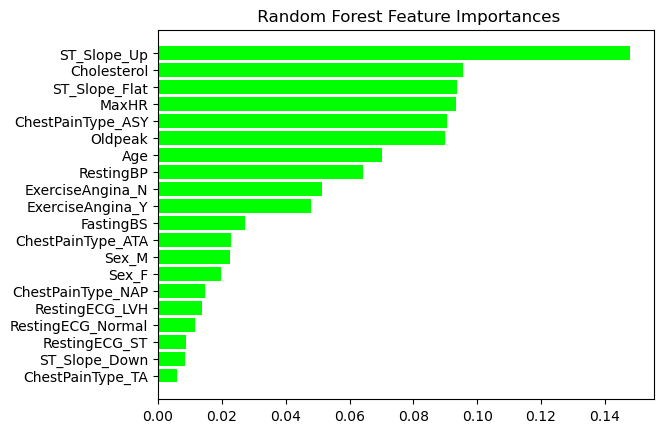

In [67]:


importances = model_rf.feature_importances_

forest_importances = pd.Series(importances, index=column_headers)
sortindices = np.argsort(forest_importances)
plt.title(' Random Forest Feature Importances')
plt.barh(range(len(sortindices)), forest_importances[sortindices], color='lime', align='center')
plt.yticks(range(len(sortindices)), [column_headers[i] for i in sortindices])
plt.show()



## LIGHTGBM

### Find the best parameters for LightGBM

In [ ]:
import lightgbm as lgb


gbe = lgb.LGBMClassifier()
#gbe = lgb.LGBMClassifier()

from sklearn.metrics import log_loss

boosted_grid = {'n_estimators': [50, 100, 150, 200],
       'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

CV_gbe = GridSearchCV(estimator=gbe, param_grid=boosted_grid, cv= 5)
CV_gbe.fit(X_train, y_train)
CV_gbe.best_params_




### Implement best parameters

In [ ]:
import lightgbm as lgb
#These were from gridsearch


model_lgb = lgb.LGBMClassifier(device="gpu",learning_rate=0.05,max_depth=8,n_estimators=100)
model_lgb.fit(X_train, y_train)


### LIGHTGBM Results

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       135
           1       0.90      0.92      0.91       168

    accuracy                           0.90       303
   macro avg       0.90      0.90      0.90       303
weighted avg       0.90      0.90      0.90       303

CONFUSION MATRIX
[[118  17]
 [ 14 154]]


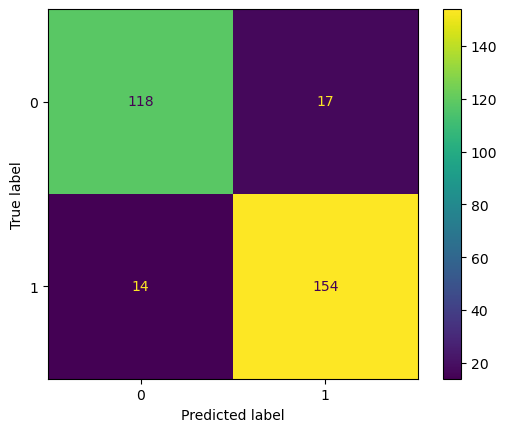

Accuracy: 0.8976897689768977
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [70]:


predicted_lgb = model_lgb.predict(X_test)
# summarize the fit of the model
print("CLASSIFICATION REPORT")
print(classification_report(y_test, predicted_lgb))


print("CONFUSION MATRIX")
cm_lgb=confusion_matrix(y_test, predicted_lgb)
print(cm_lgb)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=model_lgb.classes_)
disp_lgb.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted_lgb)
print('Accuracy:', accuracy)

arr_predicted_probs = model_lgb.predict_proba(X)[:, 1]
fpr, tpr, thresholds = roc_curve(y, arr_predicted_probs,pos_label=1)

roc_auc = auc(fpr, tpr)



### LIGHTGBM Feature Importances

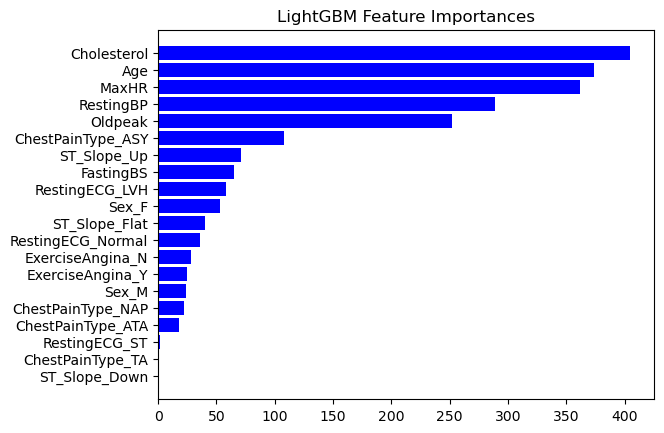

In [71]:
#FEATURE IMPORTANCES
importances = model_lgb.feature_importances_

lightgbm_importances = pd.Series(importances, index=column_headers)
sortindices = np.argsort(lightgbm_importances)
plt.title('LightGBM Feature Importances')
plt.barh(range(len(sortindices)), lightgbm_importances[sortindices], color='b', align='center')
plt.yticks(range(len(sortindices)), [column_headers[i] for i in sortindices])


plt.show()




## XGBOOST CLASSIFICATION

In [21]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# REFERENCE:https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#NOTE ABOUT REGUlARIZATION. The reg_lamba controls L2 regularization, reg_alpha l1.
#Lambda default is 1. The larger the value the more conservative
#Alpha default is 0. The larger the value the more conservative
params={'max_depth': hp.quniform("max_depth", 2, 20, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def goal(params):
    
    mm=xgb.XGBClassifier(
                    n_estimators =params['n_estimators'], max_depth = int(params['max_depth']), gamma = params['gamma'],
                    min_child_weight=int(params['min_child_weight']),
                    colsample_bytree=int(params['colsample_bytree']))
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    mm.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    prediction = mm.predict(X_test)
    accuracy = accuracy_score(y_test, prediction>0.5)
    return {'loss': -accuracy, 'status': STATUS_OK }
trials = Trials()

best_hyperparams = fmin(fn = goal,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████████████████████████████████████████| 100/100 [00:07<00:00, 14.17trial/s, best loss: -0.900990099009901]


In [22]:
print(best_hyperparams)

{'colsample_bytree': 0.8209915975359556, 'gamma': 3.316834201196341, 'max_depth': 9.0, 'min_child_weight': 10.0, 'reg_lambda': 0.7415967000661906}


### XGBoost implementation

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(colsample_bytree=0.9137467413171512 ,
                          gamma=4.316993662876307, min_child_weight= 2.0, 
                          max_depth=8, reg_alpha= 5.0, reg_lambda=0.4414490256174322 )
model_xgb.fit(X_train, y_train)


### XGBoost Results

XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       135
           1       0.89      0.93      0.91       168

    accuracy                           0.89       303
   macro avg       0.90      0.89      0.89       303
weighted avg       0.89      0.89      0.89       303

XGBoost Confusion Matrix
[[115  20]
 [ 12 156]]


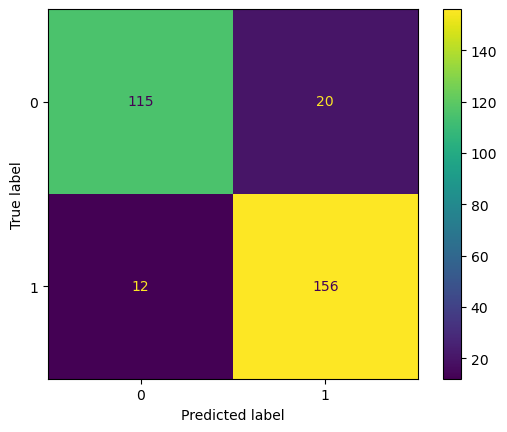

XGB Accuracy: 0.8943894389438944


In [74]:

predicted_xgb = model_xgb.predict(X_test)
# METRICS FOR THE FIT OF THE MODEL
print("XGBoost Classification Report")
print(classification_report(y_test, predicted_xgb))

print("XGBoost Confusion Matrix")
conf_mat=confusion_matrix(y_test, predicted_xgb)
print(conf_mat)
disp_conf = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model_xgb.classes_)
disp_conf.plot()
plt.show()

accuracy = accuracy_score(y_test, predicted_xgb)
print('XGB Accuracy:', accuracy)

### XGB Feature Importances

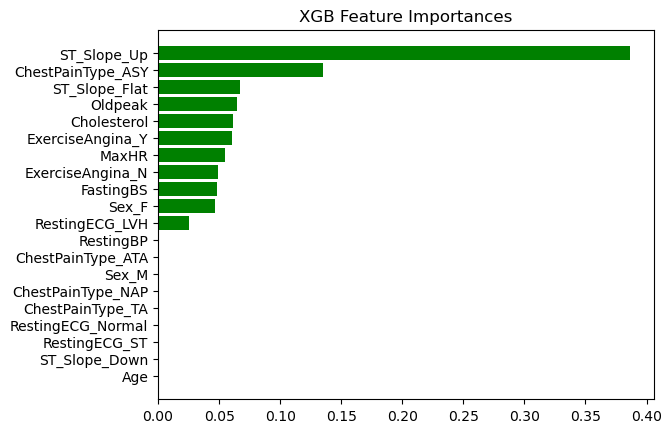

In [75]:
#FEATURE IMPORTANCES
importances = model_xgb.feature_importances_

xgb_importances = pd.Series(importances, index=column_headers)
sort_indices = np.argsort(xgb_importances)
plt.title('XGB Feature Importances')
plt.barh(range(len(sort_indices)), xgb_importances[sort_indices], color='green', align='center')
plt.yticks(range(len(sort_indices)), [column_headers[i] for i in sort_indices])
plt.show()

## CATBOOST

### Create X for Catboost

In [76]:


heart2_cat=heart.copy(deep=True)
Xcat = heart2_cat.drop('HeartDisease',axis=1)

column_headers_cat = list(Xcat.columns.values)
Xcat['Sex']=Xcat['Sex'].astype('category')
Xcat['ChestPainType']=Xcat['ChestPainType'].astype('category')
Xcat['RestingECG']=Xcat['RestingECG'].astype('category')
Xcat['FastingBS']=Xcat['FastingBS'].astype('category')
Xcat['ExerciseAngina']=Xcat['ExerciseAngina'].astype('category')
Xcat['ST_Slope']=Xcat['ST_Slope'].astype('category')
print(Xcat.dtypes)

Age                  int64
Sex               category
ChestPainType     category
RestingBP            int64
Cholesterol          int64
FastingBS         category
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
dtype: object


### Split into Training and Testing Sets for CatBoost

In [77]:
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(Xcat, y,test_size=0.3, random_state=42)


ycat_train= ycat_train.values.reshape(-1,1)
ycat_test= ycat_test.values.reshape(-1,1)


### Fit the CatBoost Model

In [ ]:
import catboost as cb


#List of categorical columns
categoricalcolumns = Xcat_train.select_dtypes(include=["category"]).columns.tolist()
cat_feat = [Xcat_train.columns.get_loc(col) for col in categoricalcolumns]

#Note how categorical features are input to the fit function
model_cat = cb.CatBoostClassifier(loss_function="Logloss",iterations=1000,eval_metric="AUC")
model_cat.fit(Xcat_train, ycat_train, cat_features=cat_feat, plot=True)
 


### Catboost Results

CatBoost Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       112
           1       0.92      0.88      0.90       164

    accuracy                           0.89       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.89      0.89       276

Catboost Confusion Matrix
[[100  12]
 [ 19 145]]


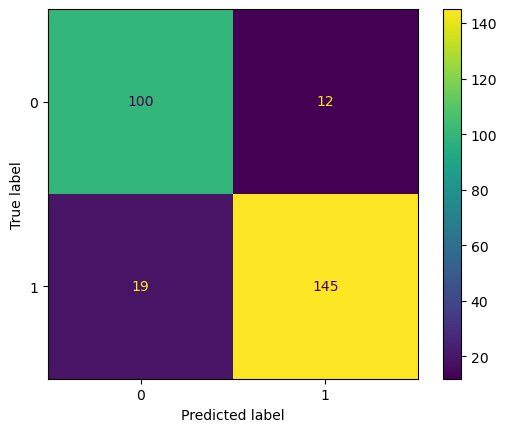

CatBoost Accuracy: 0.8876811594202898


In [79]:



predicted_cat = model_cat.predict(Xcat_test)
# METRICS FOR THE FIT OF THE MODEL
print("CatBoost Classification Report")
print(classification_report(ycat_test, predicted_cat))

print("Catboost Confusion Matrix")
conf_mat=confusion_matrix(ycat_test, predicted_cat)
print(conf_mat)
disp_conf = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=model_cat.classes_)
disp_conf.plot()
plt.show()

accuracy = accuracy_score(ycat_test, predicted_cat)
print('CatBoost Accuracy:', accuracy)


### Catboost feature importance

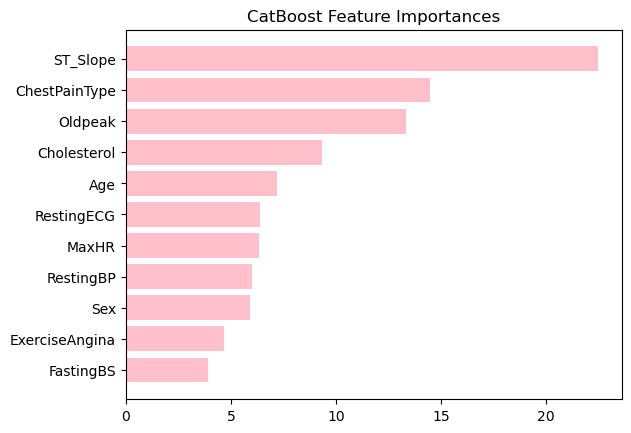

In [80]:
#FEATURE IMPORTANCES
importances = model_cat.feature_importances_

catboost_importances = pd.Series(importances, index=column_headers_cat)
sort_indices = np.argsort(catboost_importances)
plt.title('CatBoost Feature Importances')
plt.barh(range(len(sort_indices)), catboost_importances[sort_indices], color='pink', align='center')
plt.yticks(range(len(sort_indices)), [column_headers_cat[i] for i in sort_indices])
plt.show()


### COMBINED ROC PLOT

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


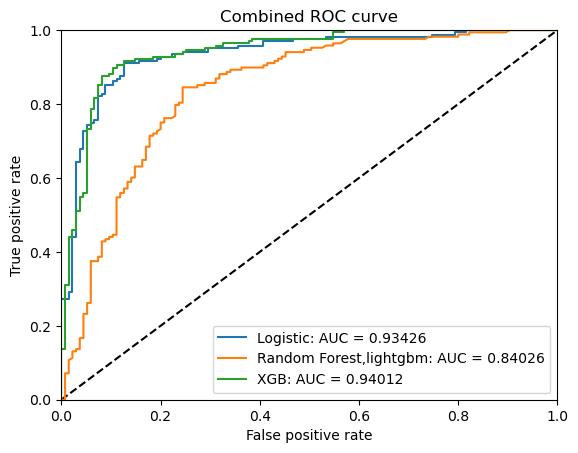

In [91]:
def plot_roc(arr_models, arr_str_model_labels):
    plt.plot([0, 1], [0, 1], 'k--')   # Reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("Combined ROC curve")
    for model, str_label in zip(arr_models, arr_str_model_labels):
        arr_predicted_probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, arr_predicted_probs,pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label="%s: AUC = %0.5f" % (str_label, roc_auc))
    plt.legend(loc="lower right")
    plt.show()
    
    
    
    
plot_roc([model1, model_rf, model_lgb, model_xgb], ["Logistic","Random Forest,""lightgbm", "XGB"])


### Sequential Feature Selection (A Wrapper Technique)

In [82]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
SFS = SequentialFeatureSelector(knn, direction='forward',cv=2,n_features_to_select="auto")
SFS.fit(X_train, y_train)
SFSDF = pd.DataFrame(columns = ['FeatureName', 'Filter'])
SFSDF['FeatureName'] = X.columns.values
SFSDF['Filter'] = SFS.get_support().tolist()
SFSDF_n = SFSDF[SFSDF['Filter']==True]
SFS_top_features = SFSDF_n['FeatureName'].tolist()
print(SFS_top_features)


['Cholesterol', 'FastingBS', 'MaxHR', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']


## Feature Selection Using RFECV (A Wrapper method)

In [84]:
from sklearn.feature_selection import RFECV

neigh = LogisticRegression()
select_engine = RFECV(neigh, step=1, cv=5)

select_engine.fit(X_train, y_train)
mask = select_engine.get_support()
print(column_headers)
features=np.array(column_headers)
sel_features = features[mask]

print("Selected Features: ", sel_features.shape[0])
print(sel_features)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
Selected Features:  15
['Cholesterol' 'FastingBS' 'MaxHR' 'Sex_F' 'Sex_M' 'ChestPainType_ASY'
 'ChestPainType_ATA' 'ChestPainType_NAP' 'ChestPainType_TA'
 'RestingECG_LVH' 'ExerciseAngina_N' 'ExerciseAngina_Y' 'ST_Slope_Down'
 'ST_Slope_Flat' 'ST_Slope_Up']


### Feature Selection Using the Boruta Algorithm (A Wrapper Technique)

In [83]:

from boruta import BorutaPy

boruta = BorutaPy(estimator = model_rf, n_estimators = 'auto',max_iter = 50,)

boruta.fit(np.array(X_train), np.ravel(y_train))

green_area = X.columns[boruta.support_].to_list()

print('Selected Features:', green_area)


Selected Features: ['Age', 'Cholesterol', 'MaxHR', 'Oldpeak', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Flat', 'ST_Slope_Up']
